In [1]:
import gspread
from google.oauth2.service_account import Credentials

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from linkml_runtime.utils.schemaview import SchemaView
import re

import pprint

from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A

The environmental triad squad did thorough voting on the classes to include in the soil env_local_scale value set

https://docs.google.com/spreadsheets/d/1epul_bXtEOlmIZYNRhngulI3-HaHhe_tU_BPUia5isQ/edit?gid=154155133#gid=154155133

After that, MAM wrote a notebook that tried to generalize the insights from those votes.

https://github.com/microbiomedata/submission-schema/blob/v11.2.0/notebooks/environmental_context_value_sets/soil/env_local_scale/post_google_sheets_soil_env_local_scale.ipynb

The output of that notebook deviated significantly from the votes, so this new notebook has been written to generate output that is more aligned with the votes.

Each person's vote for a class can be -1 (don't include it in the value set), 0 (or blank, meaning I don't have a strong opinion) or +1 (include it in the value set). The votes from all of the squad members are aggregated with two metrics: the sum of the votes and the inter annotator score. The IAA values gave usuful perspectives to the voting process, but CJM has suggested that the value set shouldn't be constrained by them any longer. So we have concluded that any class whose vote sum is 1 or greater should be included in the value set.

These approved classes include some subclasses of EnvO's 'environmental zone' class, ENVO:01000408.

See https://www.ebi.ac.uk/ols4/ontologies/envo/classes/http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252FENVO_01000408?lang=en

Most (but not all) of the environmental zones have labels that begin with 'area of...'. In general, we are including them because they share an inSubset value of 'nlcd2011', indicating that they represent land cover types specified by the USGS. 

See https://www.usgs.gov/centers/eros/science/national-land-cover-database

MAM and CJM have raised issues with EnvO regarding two aspects of that modelling, but we still include these NLCD-inspired environmental zones while that is sorted out.
- https://github.com/EnvironmentOntology/envo/issues/1583
- https://github.com/EnvironmentOntology/envo/issues/1527

In [2]:
# Set your thresholds
vote_sum_threshold = 1  # Example threshold
IAA_score_threshold = 0.0  # Example threshold

In [3]:
output_file = "post_google_sheets_soil_env_local_scale.tsv"

In [4]:
schema_with_mam_biased_sels_url = "https://raw.githubusercontent.com/microbiomedata/submission-schema/refs/tags/v11.2.0/src/nmdc_submission_schema/schema/nmdc_submission_schema.yaml"

In [5]:
sels_enum_name = "EnvLocalScaleSoilEnum"

Get voting sheet directly from Google Sheets. Requires a credentials file, which must be requested from MAM.

In [6]:
# 1. Replace with the path to your downloaded JSON key file
SERVICE_ACCOUNT_FILE = 'env-context-voting-sheets-29d0d970ca1d.json'  


In [7]:
# Consolidated_soil-env-local-scale-evidence-table
SPREADSHEET_ID = "1epul_bXtEOlmIZYNRhngulI3-HaHhe_tU_BPUia5isQ"


In [8]:
sheet_name = 'soil-env-local-scale-evidence-t'  

In [9]:
# Set up credentials
SCOPES = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]


In [10]:
envo_adapter_string  = "sqlite:obo:envo"

In [11]:
ABP = 'ENVO:01000813'

In [12]:
## code starts here

In [13]:
def compare_curie_dicts(input_dict):
  """
  Compares two dictionaries of curies and labels and reports differences 
  and common elements.

  Args:
    input_dict: A dictionary with two keys representing the group labels and 
                 the values being dictionaries of curie: label pairs.

  Returns:
    A dictionary with three keys:
      - 'first_only': A dictionary of curie: label pairs present only in 
                       the first group.
      - 'second_only': A dictionary of curie: label pairs present only in 
                        the second group.
      - 'shared': A dictionary of curie: label pairs present in both groups.
  """

  group1_label, group1_data = list(input_dict.items())[0]
  group2_label, group2_data = list(input_dict.items())[1]

  first_only_curies = set(group1_data.keys()) - set(group2_data.keys())
  second_only_curies = set(group2_data.keys()) - set(group1_data.keys())
  shared_curies = set(group1_data.keys()) & set(group2_data.keys())

  first_only = {curie: group1_data[curie] for curie in first_only_curies}
  second_only = {curie: group2_data[curie] for curie in second_only_curies}
  shared = {curie: group1_data[curie] for curie in shared_curies}

  return {
      f'{group1_label} only': first_only,
      f'{group2_label} only': second_only,
      'shared': shared
  }

In [14]:
def tabulate_core_ancestor_counts(
    curies,
    adapter,
    predicates=[IS_A],
    omit_max_count=True,
    min_count_threshold=2,
):
    """
    Tabulates the number of times each ancestor curie appears for a list of 
    input curies, with options to exclude maximum counts and a minimum count 
    threshold.

    Args:
      curies: A list of curies to get ancestors for.
      adapter: The adapter object to use for fetching ancestors (e.g., an 
               instance of OntoBiotopeAdapter).
      predicates: A list of predicates to use for traversing the ancestor 
                  hierarchy (default: [IS_A]).
      omit_max_count: Whether to omit rows with the maximum count 
                      (default: True).
      min_count_threshold: The minimum count threshold for excluding rows 
                           (default: 2).

    Returns:
      A pandas DataFrame with three columns:
        - 'ancestor_curie': The ancestor curie.
        - 'ancestor_curie_label': The label of the ancestor curie.
        - 'ancestor_curie_count': The number of times this ancestor appears.
    """

    ancestor_counts = {}
    for curie in curies:
        ancestors = adapter.ancestors(curie, predicates=predicates)
        for ancestor_curie in ancestors:
            if ancestor_curie not in ancestor_counts:
                ancestor_counts[ancestor_curie] = {
                    'ancestor_curie_label': adapter.label(ancestor_curie),
                    'ancestor_curie_count': 0
                }
            ancestor_counts[ancestor_curie]['ancestor_curie_count'] += 1

    df = pd.DataFrame(ancestor_counts).transpose().reset_index()

    # Apply filtering
    if omit_max_count:
        max_count = df['ancestor_curie_count'].max()
        df = df[df['ancestor_curie_count'] != max_count]

    df = df[df['ancestor_curie_count'] >= min_count_threshold]
    
    df = df.sort_values(by='ancestor_curie_count', ascending=False)

    return df

In [15]:

def check_descendants(curies, root_curie, adapter):
    """
    Determines whether a list of curies are descendants of a given root curie.

    Args:
      curies: A list of curies to check.
      root_curie: The curie of the root class.
      adapter: The adapter object to use for fetching ancestors and labels.

    Returns:
      A pandas DataFrame with three columns:
        - 'curie': The input curie.
        - 'label': The label of the input curie.
        - 'is_{root_label_in_snake_case}': Boolean indicating whether the 
                                          curie is a descendant of the root.
    """

    root_label_snake_case = adapter.label(root_curie).lower().replace(" ", "_")
    is_descendant_column = f'is_{root_label_snake_case}'

    results = []
    for curie in curies:
        ancestors = adapter.ancestors(curie)
        is_descendant = root_curie in ancestors
        results.append({
            'curie': curie,
            'label': adapter.label(curie),
            is_descendant_column: is_descendant
        })

    return pd.DataFrame(results)

In [16]:
envo_adapter = get_adapter(envo_adapter_string)

In [17]:
creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)

In [18]:
gc = gspread.authorize(creds)

In [19]:
# Open the spreadsheet
spreadsheet = gc.open_by_key(SPREADSHEET_ID) 

In [20]:
sheet = spreadsheet.worksheet(sheet_name)

In [21]:
# Get data as a list of lists
data = sheet.get_all_values()

In [22]:
# Convert to DataFrame
df = pd.DataFrame(data[1:], columns=data[0]) 

In [23]:
df

,unique_id,label,all_evidence,is_process,is_quality,is_chemical_entity,is_biome,is_aquatic_biome,is_terrestrial_biome,is_environmental_material,...,MLS_vote,MLS_comments,NMW_vote,NMW_comment,SM_vote,SM_comment,Yes = 1 No = -1 Maybe = 0,IAA_score,vote_sum,was_subjected_to_voting
0,CHEBI:24632,hydrocarbon,0.003288752467,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,...,0,0,,,,,0,1,0,
1,CHEBI:24866,salt,0.0001096250822,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,...,0,0,,,,,0,1,0,
2,CHEBI:25555,nitrogen atom,0.0006577504933,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,...,0,0,,,,,0,1,0,
3,CHEBI:26833,sulfur atom,0.0001096250822,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,...,0,0,,,,,0,1,0,
4,CHEBI:33287,fertilizer,0.03672440254,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,-1,,,,,,-3,0.4,-3,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,ENVO:00000567,calanque,,,,,,,,,...,,,,,,,,0.4,-2,FALSE
1225,ENVO:03500004,bike path,,,,,,,,,...,,,,,,,,0.4,-2,FALSE
1226,ENVO:03501248,overpass,,,,,,,,,...,,,,,,,,0.4,-2,FALSE
1227,ENVO:00000561,military training area,,,,,,,,,...,,,,,,,,0.4,-2,FALSE


In [24]:
df.columns

Index(['unique_id', 'label', 'all_evidence', 'is_process', 'is_quality',
       'is_chemical_entity', 'is_biome', 'is_aquatic_biome',
       'is_terrestrial_biome', 'is_environmental_material', 'is_soil',
       'is_enriched_soil', 'obsolete', 'non_host_oak_queries_count',
       'historical_permissible_values_count', 'NMDC_soil_count',
       'NCBI_mims_soil_trusting_CURIe_count',
       'NCBI_mims_soil_trusting_labels_count', 'GOLD_env_terr_soil_count',
       'non_host_oak_queries_frequency',
       'historical_permissible_values_frequency', 'NMDC_soil_frequency',
       'NCBI_mims_soil_trusting_CURIe_frequency',
       'NCBI_mims_soil_trusting_labels_frequency',
       'GOLD_env_terr_soil_frequency', 'CJM_Vote', 'CJM_Comments', 'MAM vote',
       'MAM comments', 'MLS_vote', 'MLS_comments', 'NMW_vote', 'NMW_comment',
       'SM_vote', 'SM_comment', 'Yes = 1 No = -1 Maybe = 0', 'IAA_score',
       'vote_sum', 'was_subjected_to_voting'],
      dtype='object')

In [25]:
# Convert 'vote_sum' to numeric
df['vote_sum'] = pd.to_numeric(df['vote_sum'], errors='coerce')

# Convert 'IAA_score' to numeric
df['IAA_score'] = pd.to_numeric(df['IAA_score'], errors='coerce') 


In [26]:
# Add jitter to 'vote_sum' and 'IAA_score'
df['vote_sum_jittered'] = df['vote_sum'] + np.random.normal(0, 0.1, size=len(df))
df['IAA_score_jittered'] = df['IAA_score'] + np.random.normal(0, 0.01, size=len(df))


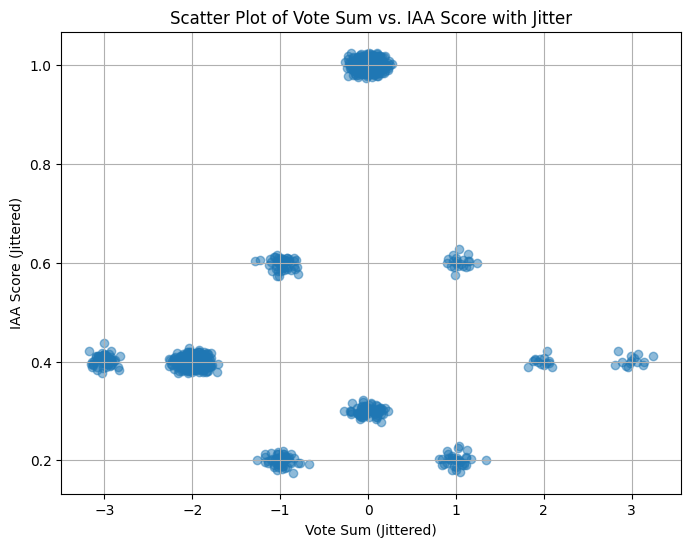

In [27]:
# Scatter plot with jittered values
plt.figure(figsize=(8, 6))
plt.scatter(df['vote_sum_jittered'], df['IAA_score_jittered'], alpha=0.5)
plt.xlabel('Vote Sum (Jittered)')
plt.ylabel('IAA Score (Jittered)')
plt.title('Scatter Plot of Vote Sum vs. IAA Score with Jitter')
plt.grid(True)
plt.show()

In [28]:
# Group by 'vote_sum' and 'IAA_score' and count the occurrences
count_table = df.groupby(['vote_sum', 'IAA_score']).size().reset_index(name='count')

In [29]:
count_table

,vote_sum,IAA_score,count
0,-3,0.4,56
1,-2,0.4,404
2,-1,0.2,54
3,-1,0.6,51
4,0,0.3,72
5,0,1.0,509
6,1,0.2,34
7,1,0.6,21
8,2,0.4,14
9,3,0.4,14


In [30]:
vote_sum_threshold

1

In [31]:
IAA_score_threshold

0.0

In [32]:
# Create the derived DataFrame
vote_filtered_df = df[(df['vote_sum'] >= vote_sum_threshold) & (df['IAA_score'] >= IAA_score_threshold)]

In [33]:
vote_filtered_df

,unique_id,label,all_evidence,is_process,is_quality,is_chemical_entity,is_biome,is_aquatic_biome,is_terrestrial_biome,is_environmental_material,...,NMW_vote,NMW_comment,SM_vote,SM_comment,Yes = 1 No = -1 Maybe = 0,IAA_score,vote_sum,was_subjected_to_voting,vote_sum_jittered,IAA_score_jittered
18,ENVO:00000011,garden,0.1188080752,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.2,1,,1.007123,0.200126
20,ENVO:00000014,canal,0.00885439641,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.6,1,,1.011190,0.603547
24,ENVO:00000020,lake,0.02299603202,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.6,1,,0.910182,0.606951
26,ENVO:00000022,river,0.0144452756,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,3,0.4,3,,2.990582,0.401571
27,ENVO:00000023,stream,0.008964021492,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,2,0.4,2,,1.905009,0.403827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,ENVO:01001568,frost heave,0.00885439641,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.6,1,,1.237414,0.599029
1072,ENVO:01001803,tropical forest,0.04140378549,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.2,1,,1.026524,0.225960
1115,ENVO:03000117,channel,0.01770879282,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,2,0.4,2,,2.027095,0.397394
1119,ENVO:03500005,anthropogenic litter,0.00885439641,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,,,,,1,0.6,1,,1.136028,0.602705


Now compare the voted-in classes with the ones that were locked into the v11.2 EnvLocalScaleSoilEnum by Mark's overly-clever code

In [34]:
schema_with_mam_biased_sels_url = SchemaView(schema_with_mam_biased_sels_url)

In [35]:
mam_biased_sels_enum = schema_with_mam_biased_sels_url.get_enum(sels_enum_name)

In [36]:
mam_biased_sels_enum_pvs = list(mam_biased_sels_enum.permissible_values.keys())

In [37]:
mam_biased_curie_label_dict = {}
for label_with_curie in mam_biased_sels_enum_pvs:
    match = re.search(r'(.*?) \[(.*?)\]', label_with_curie)  # Extract label and curie
    if match:
        label = match.group(1)
        curie = match.group(2)
        mam_biased_curie_label_dict[curie] = label


In [38]:
# Create the curie dictionary from filtered_df
votes_only_dict = dict(zip(vote_filtered_df['unique_id'], vote_filtered_df['label']))

In [39]:
input_data = {'MAM biased': mam_biased_curie_label_dict, 'Votes': votes_only_dict}

In [40]:
pvs_analysis = compare_curie_dicts(input_data)

This dictionary shows the classes that were included in 
- the v11.2 EnvLocalScaleSoilEnum by Mark's overly-clever code only
- the in-voted classes only
- the intersection of those two sets

In [41]:
pprint.pprint(pvs_analysis)

{'MAM biased only': {'ENVO:00000064': 'road',
                     'ENVO:00000074': 'dam',
                     'ENVO:00000100': 'valley',
                     'ENVO:00000108': 'meadow ecosystem',
                     'ENVO:00000127': 'badland',
                     'ENVO:00000169': 'canyon',
                     'ENVO:00000177': 'moraine',
                     'ENVO:00000181': 'nunatak',
                     'ENVO:00000276': 'drumlin',
                     'ENVO:00000277': 'dry lake',
                     'ENVO:00000280': 'escarpment',
                     'ENVO:00000282': 'esker',
                     'ENVO:00000300': 'scrubland area',
                     'ENVO:00000304': 'shore',
                     'ENVO:00000320': 'crevasse',
                     'ENVO:00000325': 'polje',
                     'ENVO:00000370': 'tuya',
                     'ENVO:00000410': 'kipuka',
                     'ENVO:00000417': 'machair',
                     'ENVO:00000418': 'ria',
                     '

Are all of the in-voted classes astronomic body parts?

Or are some environmental systems? Or something else? None of that is indiciated on the voting sheet.


In [42]:
ancestor_frame = tabulate_core_ancestor_counts(list(votes_only_dict.keys()), envo_adapter)

In [43]:
ancestor_frame

# there are limits to how useful this is for picking a root for ELS

,index,ancestor_curie_label,ancestor_curie_count
4,BFO:0000040,material entity,82
7,ENVO:01000813,astronomical body part,70
16,ENVO:01001784,compound astronomical body part,46
27,ENVO:00000191,solid astronomical body part,39
29,ENVO:01001886,landform,35
...,...,...,...
72,ENVO:00000096,caldera,2
69,ENVO:00000087,cliff,2
64,ENVO:00000081,mountain,2
63,ENVO:01001828,anthropised ecosystem,2


In [44]:
is_abp_df = check_descendants(list(votes_only_dict.keys()), ABP, envo_adapter)

In [45]:
is_abp_df

,curie,label,is_astronomical_body_part
0,ENVO:00000011,garden,True
1,ENVO:00000014,canal,True
2,ENVO:00000020,lake,True
3,ENVO:00000022,river,True
4,ENVO:00000023,stream,True
...,...,...,...
78,ENVO:01001568,frost heave,True
79,ENVO:01001803,tropical forest,True
80,ENVO:03000117,channel,True
81,ENVO:03500005,anthropogenic litter,False


In [46]:
not_abp = is_abp_df.loc[~is_abp_df['is_astronomical_body_part'], 'curie'].tolist()

Here are the in-voted classes that are not astronomical body parts

In [47]:
for i in not_abp:
    l = envo_adapter.label(i)
    print(f"{i} ! {l}")

ENVO:00000133 ! glacier
ENVO:00005803 ! animal habitation
ENVO:03500005 ! anthropogenic litter


Here are their parent classes. Maybe we want to make boolean filter columns in the voting sheets for some of them?

In [48]:
non_abp_ancestor_frame = tabulate_core_ancestor_counts(not_abp, envo_adapter, min_count_threshold=1, omit_max_count=False)

In [49]:
non_abp_ancestor_frame

,index,ancestor_curie_label,ancestor_curie_count
1,BFO:0000001,entity,3
2,BFO:0000002,continuant,3
3,BFO:0000004,independent continuant,3
5,BFO:0000040,material entity,3
0,ENVO:00000133,glacier,2
8,ENVO:00005803,animal habitation,2
10,ENVO:03500005,anthropogenic litter,2
4,BFO:0000030,object,1
6,ENVO:01001686,mass of environmental material,1
7,ENVO:01001691,mass of compounded environmental materials,1


Or maybe not

In [50]:
votes_df_to_save = vote_filtered_df[['unique_id', 'label']]

votes_df_to_save.columns = ['id','label']

In [51]:
votes_df_to_save.to_csv(output_file, index=False, sep="\t")